In [1]:
! pip install datasets prettyprint evaluate rouge_score bitsandbytes peft trl transformers torch pandas numpy
! pip install -U transformers

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [22]:
# Import necessary libraries
import torch  # PyTorch library for deep learning computations.
# Import tokenizer and model from transformers for Natural Language Processing tasks.
from datasets import Dataset, DatasetDict, load_dataset, interleave_datasets # Used for loading and managing datasets.
from transformers import  (T5ForConditionalGeneration,
                           BitsAndBytesConfig,
                           T5Tokenizer,
                           AutoModelForSeq2SeqLM,
                           TrainingArguments,
                           Trainer,
                           AutoTokenizer,
                           GenerationConfig)  # Components for model training and generation.
import time
import evaluate # Used for model evaluation metrics.
import pandas as pd # Used for data manipulation and analysis.
import numpy as np # Used for numerical computations.
from peft import  LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training # Used for parameter-efficient fine-tuning.
from trl import SFTTrainer # Used for supervised fine-tuning.
from pprint import pprint
import pandas as pd


import warnings # Used for managing warning messages.
warnings.filterwarnings("ignore") # Ignore warning messages during execution.

# Check if a CUDA-enabled GPU is available, otherwise use CPU for computations.
device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL="t5-3b"

In [16]:
# Load the pre-trained tokenizer for the "t5-small" model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [17]:

# Load the pre-trained "t5-small" model and move it to the selected device
pre_train_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL).to(device)

# Iterate through a list of English prompts
for prompt in ["Hello, How are you?", "My name is Midhun"]:
    # Print the current input prompt
    print("Input:", prompt)

    # Tokenize the input prompt and add translation instructions
    # Return PyTorch tensors and move them to the selected device
    inputTokens = tokenizer("translate English to French: {}".format(prompt), return_tensors="pt").to(device)

    # Generate the French translation using the model
    # Limit the output to a maximum of 50 tokens
    outputs = pre_train_model.generate(inputTokens['input_ids'], attention_mask=inputTokens['attention_mask'], max_new_tokens=50)

    # Decode the generated output tokens into readable text and print the translation
    # Skip special tokens (like start and end tokens) in the output
    print("Output:", tokenizer.decode(outputs[0], skip_special_tokens=True))

Input: Hello, How are you?
Output: Bonjour, Comment allez-vous?
Input: My name is Midhun
Output: Mon nom est Midhun


In [5]:
# Check memory footprint
if device == 'cuda':
    print(f"Model Memory Footprint: {pre_train_model.get_memory_footprint() / (1024 ** 3):.2f} GB")
else:
    print("Model is loaded on CPU, memory footprint is not available.")

Model Memory Footprint: 10.62 GB


In [9]:
# Load dataset
dataset_scc_train = load_dataset("b-mc2/sql-create-context", split='train[:80%]')
dataset_scc_test  = load_dataset("b-mc2/sql-create-context", split='train[-20%:-10%]')
dataset_scc_val   = load_dataset("b-mc2/sql-create-context", split='train[-10%:]')

dataset = DatasetDict({ 'train': interleave_datasets([dataset_scc_train]),
                            'test': interleave_datasets([dataset_scc_test]),
                            'validation': interleave_datasets([dataset_scc_val])})

README.md:   0%|          | 0.00/4.43k [00:00<?, ?B/s]

sql_create_context_v4.json:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78577 [00:00<?, ? examples/s]

In [6]:
from pprint import pprint
print("-----Train Dataset----")
pprint(dataset['train'][0])
print("-----Test Dataset-----")
pprint(dataset['test'][0])
print("----Test Dataset:-----")
pprint(dataset['validation'][0])

-----Train Dataset----
{'answer': 'SELECT COUNT(*) FROM head WHERE age > 56',
 'context': 'CREATE TABLE head (age INTEGER)',
 'question': 'How many heads of the departments are older than 56 ?'}
-----Test Dataset-----
{'answer': 'SELECT date FROM table_name_11 WHERE away_team = "essendon"',
 'context': 'CREATE TABLE table_name_11 (date VARCHAR, away_team VARCHAR)',
 'question': 'On what Date did the Away team essendon play?'}
----Test Dataset:-----
{'answer': 'SELECT home_team FROM table_name_80 WHERE away_team = "lincoln '
           'city"',
 'context': 'CREATE TABLE table_name_80 (home_team VARCHAR, away_team VARCHAR)',
 'question': 'What is the Home team at the Lincoln City Away game?'}


In [10]:
def tokenize_function(example):
    """
    Tokenizes the input example and prepares it for the model.

    This function takes an example from the dataset, combines the context and
    question into a prompt, tokenizes the prompt and answer using the
    pre-trained tokenizer, and returns the example with added 'input_ids'
    and 'labels'.

    Args:
        example (dict): A dictionary containing 'context', 'question', and 'answer'.

    Returns:
        dict: The modified example with added 'input_ids' and 'labels'.
    """

    # Define special tokens to mark different sections of the input
    _context = "Tables:\n"
    _question = "\n\nQuestion:\n"
    _answer = "\n\nAnswer:\n"

    # Combine context and question into a prompt
    # Create the prompt string with special tokens
    prompt = [_context + context + _question + question + _answer for context, question in zip(example['context'], example['question'])]

    # Tokenize the prompt and store as 'input_ids'
    # Add padding='max_length' to ensure all sequences have the same length
    # Use padding=True and truncation=True to handle varying sequence lengths
    # and ensure consistency in tensor shapes.
    example['input_ids'] = tokenizer(prompt, padding='max_length',max_length=512, truncation=True, return_tensors="pt").input_ids

    # Tokenize the answer and store as 'labels'
    # Add padding='max_length' to ensure all sequences have the same length
    # Use padding=True and truncation=True to handle varying sequence lengths
    # and ensure consistency in tensor shapes.
    example['labels'] = tokenizer(example['answer'], padding='max_length',max_length=200, truncation=True, return_tensors="pt").input_ids

    return example


# Apply the tokenize_function to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)
# Remove original text columns, as they are now represented by 'input_ids' and 'labels'
tokenized_datasets = tokenized_datasets.remove_columns(['question', 'context', 'answer'])
print("Tokenized Dataset")

Map:   0%|          | 0/62862 [00:00<?, ? examples/s]

Map:   0%|          | 0/7857 [00:00<?, ? examples/s]

Map:   0%|          | 0/7858 [00:00<?, ? examples/s]

Tokenized Dataset


In [11]:
pprint(tokenized_datasets.keys())
pprint(tokenized_datasets['train'][0].keys())
pprint(tokenized_datasets['train'][0]['input_ids'][:10])
pprint(tokenized_datasets['train'][0]['labels'][:10])
pprint(tokenized_datasets)

dict_keys(['train', 'test', 'validation'])
dict_keys(['input_ids', 'labels'])
[4398, 7, 10, 205, 4386, 6048, 332, 17098, 819, 41]
[3, 23143, 14196, 2847, 17161, 599, 1935, 61, 21680, 819]
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 62862
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 7857
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 7858
    })
})


In [11]:
index = 555  # Set the index to 555 to select the first example from the dataset

# Get the question, context, and answer from the 'test' split of the dataset
question = dataset['test'][index]['question']
context = dataset['test'][index]['context']
answer = dataset['test'][index]['answer']

# Create the prompt by formatting the context and question
prompt = f"""Tables:
{context}

Question:
{question}

Answer:
"""

# Tokenize the prompt and convert it to PyTorch tensors
inputs = tokenizer(prompt, return_tensors='pt')
# Move the input tensors to the 'cuda' device (GPU) if available
inputs = inputs.to('cuda')

# Generate the answer using the pre-trained model
output = tokenizer.decode(
    pre_train_model.generate(
        inputs["input_ids"],  # Pass the tokenized input to the model
        max_new_tokens=25,  # Limit the output to a maximum of 200 tokens
    )[0],  # Get the first element of the generated output
    skip_special_tokens=True  # Remove special tokens from the output
)

# Create a dashed line for visual separation in the output
dash_line = '-'.join('' for x in range(100))
# Print the prompt, actual answer, and the model's generated answer
print(dash_line)
print(f'Prompt:\n{prompt}')
print(dash_line)
print(f'Actual answer:\n{answer}\n')
print(dash_line)
pprint(f'Pre-trained Model Answer - Zero Zhot:\n\n{output}')

---------------------------------------------------------------------------------------------------
Prompt:
Tables:
CREATE TABLE table_name_33 (d_41 VARCHAR, r_51 VARCHAR)

Question:
Tell me the D 41 and R 51 of r 11

Answer:

---------------------------------------------------------------------------------------------------
Actual answer:
SELECT d_41 FROM table_name_33 WHERE r_51 = "r 11"

---------------------------------------------------------------------------------------------------
'Pre-trained Model Answer - Zero Zhot:\n\nD 41 and R 51 of r 11'


In [23]:
# unloding the model from memory
del trainer
torch.cuda.empty_cache()

In [6]:
# Get the data type for float16 from the PyTorch library.
# This will be used for computations during quantization.
compute_dtype = getattr(torch, "float16")

# Create a BitsAndBytesConfig object to configure quantization settings.
# This is used to optimize the model's memory footprint and inference speed.
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,  # Load the model weights in 4-bit precision.
        bnb_4bit_quant_type="nf4",  # Use the NF4 quantization type for 4-bit weights.
        bnb_4bit_compute_dtype=compute_dtype,  # Use float16 for computations during quantization.
        bnb_4bit_use_double_quant=True,  # Enable double quantization for further optimization.
)

In [7]:
model_q = AutoModelForSeq2SeqLM.from_pretrained(MODEL,quantization_config=bnb_config).to(device)

model_q.get_memory_footprint()
pprint(model_q)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/11.4G [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear4bit(in_features=1024, out_features=4096, bias=False)
              (k): Linear4bit(in_features=1024, out_features=4096, bias=False)
              (v): Linear4bit(in_features=1024, out_features=4096, bias=False)
              (o): Linear4bit(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear4bit(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, bias=F

In [8]:
# Define the configuration for LoRA (Low-Rank Adaptation) using LoraConfig
peft_config = LoraConfig(
        inference_mode=False,  # Set to False for inference_mode
        lora_alpha=16,  # Scaling factor for the LoRA updates. Controls the impact of LoRA layers.
        lora_dropout=0.5,  # Dropout probability for the LoRA layers, helps prevent overfitting.
        r=16,  # Rank of the LoRA update matrices. Lower rank leads to fewer trainable parameters.
        bias="none",  # Whether to add a bias term to the LoRA layers. "none" means no bias is added.
        task_type=TaskType.SEQ_2_SEQ_LM,# Specifies the task type as sequence-to-sequence language modeling.
        target_modules=["q", "v", "o"],  # Specifies the modules to which LoRA will be applied. Here, it's applied to 'q' and 'v' modules.
        modules_to_save=["lm_head"],
        )


In [9]:
# from peft import get_peft_model

# model = get_peft_model(model, peft_config)

model_q.add_adapter(peft_config, adapter_name="adapter_text2sql")
model_q.set_adapter("adapter_text2sql")
pprint(model_q)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1024, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (adapter_text2sql): Dropout(p=0.5, inplace=False)
                )
                (lora_A): ModuleDict(
                  (adapter_text2sql): Linear(in_features=1024, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (adapter_text2sql): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
         

In [10]:
# Check memory footprint
if device == 'cuda':
    print(f"Model Memory Footprint: {model_q.get_memory_footprint() / (1024 ** 3):.2f} GB")
else:
    print("Model is loaded on CPU, memory footprint is not available.")

Model Memory Footprint: 4.13 GB


In [19]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = model.num_parameters()
    for _, param in model.named_parameters():
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
print_trainable_parameters(model_q)


trainable params: 50593792 || all params: 2902192128 || trainable%: 1.7432957491641297


In [20]:
# Set the directory to save the fine-tuned model and its checkpoints
output_dir = f'./peft_fine_tuning_text2sql-{str(int(time.time()))}'

# Define training arguments using the TrainingArguments class
training_args = TrainingArguments(
    output_dir=output_dir,  # Directory to save model checkpoints
    eval_strategy='steps',
    eval_steps=5000,
    optim="paged_adamw_8bit",  #used with QLoRA
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    weight_decay=0.01,
    learning_rate=2e-5,
    num_train_epochs=0.5,
    report_to='none',  # Disable reporting to Weights & Biases (wandb.ai)
)

# Create a Trainer instance to manage the fine-tuning process
trainer = Trainer(
    model=model_q,  # The model to fine-tune
    args=training_args,  # Training arguments
    train_dataset=tokenized_datasets['train'],  # Training dataset
    eval_dataset=tokenized_datasets['validation'],  # Evaluation dataset
)

# Start the fine-tuning process
trainer.train()

# Save the fine-tuned model to a directory
model_q.save_pretrained("model_q_text2sql")

OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 896.00 KiB is free. Process 11642 has 39.54 GiB memory in use. Of the allocated memory 38.67 GiB is allocated by PyTorch, and 367.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [12]:
fine_tuned_model = AutoModelForSeq2SeqLM.from_pretrained("model_q_text2sql")
fine_tuned_model = fine_tuned_model.to('cuda')

In [16]:
index = 555  # Set the index to 555 to select the first example from the dataset

# Get the question, context, and answer from the 'test' split of the dataset
question = dataset['test'][index]['question']
context = dataset['test'][index]['context']
answer = dataset['test'][index]['answer']

# Create the prompt by formatting the context and question
prompt = f"""Tables:
{context}

Question:
{question}

Answer:
"""

# Tokenize the prompt and convert it to PyTorch tensors
inputs = tokenizer(prompt, return_tensors='pt')
# Move the input tensors to the 'cuda' device (GPU) if available
inputs = inputs.to('cuda')

# Generate the answer using the pre-trained model
output = tokenizer.decode(
    fine_tuned_model.generate(
        inputs["input_ids"],  # Pass the tokenized input to the model
        max_new_tokens=200,  # Limit the output to a maximum of 25 tokens
    )[0],  # Get the first element of the generated output
    skip_special_tokens= True #Remove special tokens from the output
)

# Create a dashed line for visual separation in the output
dash_line = '-'.join('' for x in range(100))
# Print the prompt, actual answer, and the model's generated answer
print(dash_line)
print(f'Prompt:\n{prompt}')
print(dash_line)
print(f'Actual answer:\n{answer}\n')
print(dash_line)
pprint(f'fine_tuned_model Answer - Zero Zhot:\n\n{output}')

---------------------------------------------------------------------------------------------------
Prompt:
Tables:
CREATE TABLE table_name_33 (d_41 VARCHAR, r_51 VARCHAR)

Question:
Tell me the D 41 and R 51 of r 11

Answer:

---------------------------------------------------------------------------------------------------
Actual answer:
SELECT d_41 FROM table_name_33 WHERE r_51 = "r 11"

---------------------------------------------------------------------------------------------------
'fine_tuned_model Answer - Zero Zhot:\n\nD 41 and R 51 of r 11'


In [18]:

# Iterate through a list of English prompts
for prompt in ["Hello, How are you?", "My name is Midhun"]:
    # Print the current input prompt
    print("Input:", prompt)

    # Tokenize the input prompt and add translation instructions
    # Return PyTorch tensors and move them to the selected device
    inputTokens = tokenizer("translate English to French: {}".format(prompt), return_tensors="pt").to(device)

    # Generate the French translation using the model
    # Limit the output to a maximum of 50 tokens
    outputs = fine_tuned_model.generate(inputTokens['input_ids'], attention_mask=inputTokens['attention_mask'], max_new_tokens=50)

    # Decode the generated output tokens into readable text and print the translation
    # Skip special tokens (like start and end tokens) in the output
    print("Output:", tokenizer.decode(outputs[0], skip_special_tokens=True))


Input: Hello, How are you?
Output: Bonjour, Comment allez-vous?
Input: My name is Midhun
Output: Mon nom est Midhun


In [11]:
! cp -r /content/drive/MyDrive/LLM_fine_tuning/model_q_text2sql /content/

## Evaluate the Model Quantitatively (with ROUGE Metric)

In [23]:
# Perform inferences for test dataset. Do 25 only, due to time it takes.

questions = dataset['test'][0:25]['question']
contexts = dataset['test'][0:25]['context']
human_baseline_answers = dataset['test'][0:25]['answer']

original_model_answers = []
finetuned_model_answers = []

for idx, question in enumerate(questions):

    prompt = f"""Tables:
{contexts[idx]}

Question:
{question}

Answer:
"""

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids
    input_ids = input_ids.to('cuda')

    human_baseline_text_output = human_baseline_answers[idx]

    original_model_outputs = pre_train_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=300))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_answers.append(original_model_text_output)

    finetuned_model_outputs = fine_tuned_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=300))
    finetuned_model_text_output = tokenizer.decode(finetuned_model_outputs[0], skip_special_tokens=True)
    finetuned_model_answers.append(finetuned_model_text_output)

zipped_summaries = list(zip(human_baseline_answers, original_model_answers, finetuned_model_answers))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_answers', 'original_model_answers', 'finetuned_model_answers'])

rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_answers,
    references=human_baseline_answers[0:len(original_model_answers)],
    use_aggregator=True,
    use_stemmer=True,
)
print('ORIGINAL MODEL:')
print(original_model_results)


finetuned_model_results = rouge.compute(
    predictions=finetuned_model_answers,
    references=human_baseline_answers[0:len(finetuned_model_answers)],
    use_aggregator=True,
    use_stemmer=True,
)
print('FINE-TUNED MODEL:')
print(finetuned_model_results)


`generation_config` default values have been modified to match model-specific defaults: {'pad_token_id': 0, 'eos_token_id': 1, 'decoder_start_token_id': 0}. If this is not desired, please set these values explicitly.


ORIGINAL MODEL:
{'rouge1': np.float64(0.36909067729655964), 'rouge2': np.float64(0.2108754578754579), 'rougeL': np.float64(0.33789630739630744), 'rougeLsum': np.float64(0.33828134175193)}
FINE-TUNED MODEL:
{'rouge1': np.float64(0.36340115096461834), 'rouge2': np.float64(0.19589221889221892), 'rougeL': np.float64(0.3535362576879605), 'rougeLsum': np.float64(0.3565740336375012)}


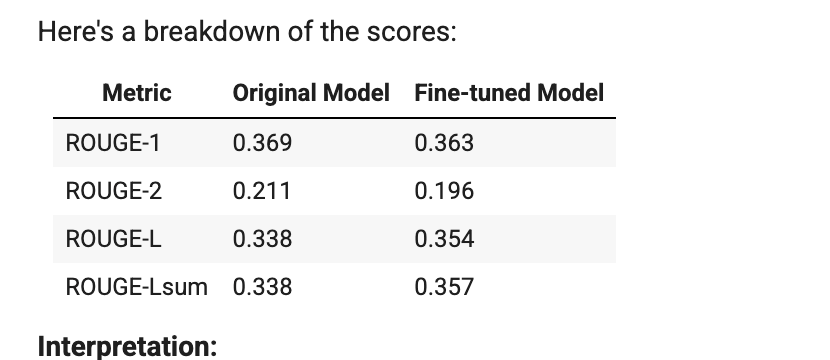


ROUGE-L and ROUGE-Lsum: These metrics consider the longest common subsequence (LCS) between the generated and reference texts, which gives a better indication of overall sentence similarity. Here, the fine-tuned model has noticeably higher ROUGE-L and ROUGE-Lsum scores compared to the original model. This suggests that the fine-tuned model might have generated text that is more semantically similar to the reference text, even if it doesn't have as much word-for-word overlap.

